<div><img style="float: right; width: 120px; vertical-align:rigth" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />



<h1><center>Standford Car Dataset</center></h1>

<center>Proyecto de Ciencia de Datos</center>
<center>Grado en Ciencia de Datos e Inteligencia Artificial</center>
<center>Escuela Técnica Superior de Ingeniería de Sistemas Informáticos</center>
<center>2023-2024</center>



En este proyecto se va a trabajar con el dataset de [Stanford Car Dataset](https://www.kaggle.com/datasets/jessicali9530/stanford-cars-dataset) de [Kaggle](https://www.kaggle.com/) que contiene 16.185 imágenes de 196 clases de coches. El dataset está dividido en 8.144 imágenes de entrenamiento y 8.041 imágenes de test. 

En específico, se ha optado por trabajar con el dataset de [Stanford Car Dataset by classes folder](https://www.kaggle.com/jutrera/stanford-car-dataset-by-classes-folder) que contiene las imágenes de los coches divididas en carpetas por clases *(y las clases del dataset original no están correctamente etiquetadas)*.

<span style="color:orange">**NOTA**</span>: Se recomienda el uso de GPU para la ejecución de este notebook si se desea entrenar los modelos de redes neuronales. No obstante, para una mayor facilidad de uso, se ha optado por entrenar los modelos y posteriormente guardarlos en la carpeta `models` para su posterior uso.

Dado que se está haciendo uso de GPU en Windows mediante [WSL2](https://docs.microsoft.com/en-us/windows/wsl/about) y [CUDA](https://developer.nvidia.com/cuda-zone), la siguiente celda nos permite evitar ciertos <span style="color:red">warnings</span> que aparecen al ejecutar el notebook pero que no afectan al funcionamiento del mismo.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Import Libraries


In [2]:
# Obtain current working directory
os.chdir('..')

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# Variables containing the paths
from settings import settings

# Auxiliar functions for data processing and visualization
from auxiliar_functions.img_generator import  create_img_generator
from auxiliar_functions.plot_functions import plot_evaluation, plot_comparison, plot_imgs_from_generator, plot_samples

# Call the models from scratch
from models.vgg_16 import VGG16
from models.lenet import LeNet
from models.alexnet import AlexNet
from models.resnet_50 import ResNet50
from models.googlenet import GoogleNet

2023-12-13 21:42:13.871480: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-13 21:42:13.871521: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-13 21:42:13.871537: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Check GPU Availability

Las siguientes 3 celdas nos permiten comprobar si tenemos GPU disponible para su uso en el notebook.

In [4]:
# Check if GPU is running
print(len(tf.config.list_physical_devices('GPU')) > 0)

# See GPU devices in use
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

# Set memory growth to True. This will allow to allocate memory as needed
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load and Visualize the Dataset

A continuación, se cargan las imágenes del dataset y se visualizan algunas de ellas. Todos los directorios que se van a utilizar en este repositorio se van a almacenar en la <span style="color:#20B2AA">**settings.py**</span> para su fácil acceso.

In [5]:
# Get train and test paths
train_path, test_path = settings.train, settings.test

# Load train and test data
train = pd.read_csv(settings.data_train, header=None)
test = pd.read_csv(settings.data_test, header=None)
train.shape, test.shape

((8144, 6), (8041, 6))

El archivo <span style="color:#20B2AA">**names.csv**</span> contiene los 196 nombres de las clases de coches que se van a utilizar en este proyecto. Se requiere un pequeño preprocesamiento para sustituir $/$ por $-$ dado que posteriormente se van a utilizar como nombres de carpetas y los $/$ ocasionan problemas.

In [6]:
# Load model names
model_names = pd.read_csv(settings.car_model, header=None)[0].tolist()

# Correct model names for them to be turned into folder name
model_names = [name.replace('/', '-') for name in model_names]

print(len(model_names), '\n', model_names[:5])

196 
 ['AM General Hummer SUV 2000', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012']


In [7]:
train.head()

,0,1,2,3,4,5
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106


El dataset contiene las siguientes columnas:

- La columna 0 contiene el nombre de la imagen dentro de cada carpeta.
- La columna 1 hace referencia a la coordenada `x` del punto superior izquierdo del cuadro delimitador.
- La columna 2 hace referencia a la coordenada `y` del punto superior izquierdo del cuadro delimitador.
- La columna 3 hace referencia a la coordenada `x` del punto inferior derecho del cuadro delimitador.
- La columna 4 hace referencia a la coordenada `y` del punto inferior derecho del cuadro delimitador.
- La columna 5 hace referencia a la clase del coche.

Mediante el archivo que contiene los diferentes modelos y la columna 5 del dataset, se obtiene el nombre de la clase del coche al que pertenece cada imagen.

<span style="color:orange">**NOTA**</span>: Dado que el carácter $/$ ocasiona problemas en el nombre de las carpetas, se ha optado por sustituirlo por $-$, que es la manera en la que se nomrbra a las carpetas con cada modelo.

In [8]:
# Change Column Names
train.columns = test.columns = ['img_name', 'x', 'y', 'width', 'height', 'label']
test.columns = ['img_name', 'x', 'y', 'width', 'height', 'label']

# For each item in df, find the corresponding model name
train['model'] = train.label.apply(lambda x: model_names[x-1])
test['model'] = test.label.apply(lambda x: model_names[x-1])

# Correct model names for them to be turned into folder name
train['model'] = train.model.apply(lambda x: x.replace('/', '-'))
test['model'] = test.model.apply(lambda x: x.replace('/', '-'))

In [9]:
train.head()

,img_name,x,y,width,height,label,model
0,00001.jpg,39,116,569,375,14,Audi TTS Coupe 2012
1,00002.jpg,36,116,868,587,3,Acura TL Sedan 2012
2,00003.jpg,85,109,601,381,91,Dodge Dakota Club Cab 2007
3,00004.jpg,621,393,1484,1096,134,Hyundai Sonata Hybrid Sedan 2012
4,00005.jpg,14,36,133,99,106,Ford F-450 Super Duty Crew Cab 2012


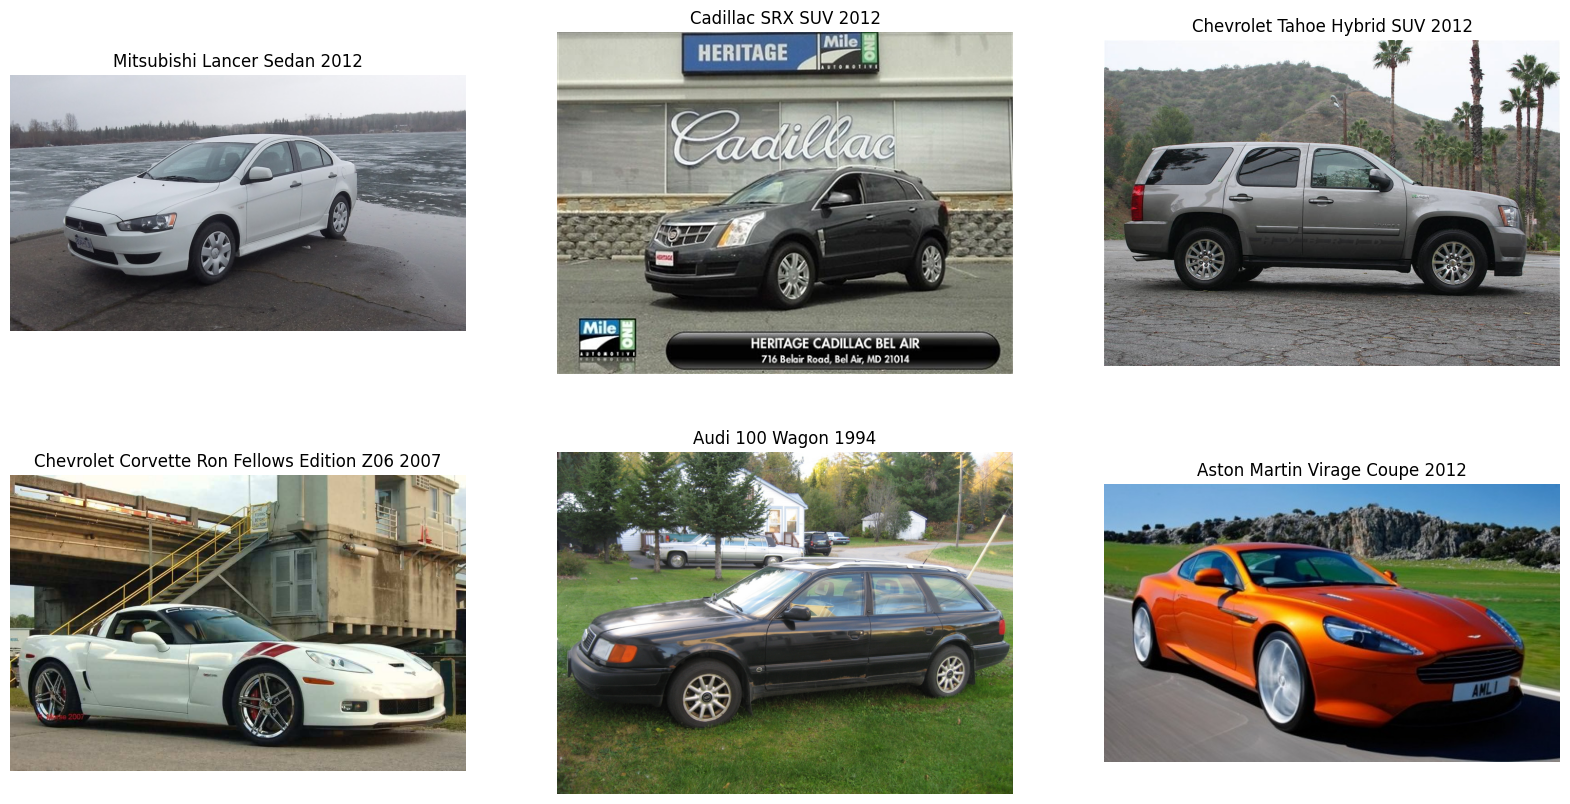

In [10]:
plot_samples(train)

In [11]:
# Check Image Sizes
sample_img = plt.imread(settings.train + train['model'][0] + '/00001.jpg')
print(f'Las dimensiones de la imagen son: {sample_img.shape}')

Las dimensiones de la imagen son: (400, 600, 3)


## Data Preprocessing

Dado que en este notebook va a implementar todos los modelos CNN vistos en clase, se va a realizar un preprocesamiento de los datos para que se ajusten a las necesidades de cada modelo. Para ello, se hará uso de la función ``ImageDataGenerator`` y de la función ``flow_from_directory``. Ambas funciones han sido recogidas en una función personalizada llamada ``create_img_generator``.

- ``ImageDataGenerator``: Esta función nos permite generar un flujo de datos a partir de las imágenes que se encuentran en un directorio. El preprocesamiento que se va a realizar es el siguiente:
    - ``rescale``: Se va a reescalar cada imagen dividiendo cada pixel por 255.
    - ``rotation_range``: Se va a rotar cada imagen 20 grados.
    - ``width_shift_range``: Se va a desplazar cada imagen horizontalmente un 20% de su ancho.
    - ``height_shift_range``: Se va a desplazar cada imagen verticalmente un 20% de su altura.
    - ``horizontal_flip``: Se va a voltear cada imagen horizontalmente.
    - ``zoom_range``: Se va a hacer zoom a cada imagen 20%.
    - ``fill_mode``: Se va a rellenar el espacio que queda vacío al rotar o desplazar cada imagen con el valor más cercano.
    - ``validation_split``: Se va a dividir el dataset en un 80% para entrenamiento y un 20% para validación.

- ``flow_from_directory``: Esta función nos permite generar un flujo de datos a partir de las imágenes que se encuentran en un directorio. Una de las mayores ventajas es que la función supone que las imágenes se encuentran en carpetas separadas por clases, por lo que no es necesario especificar las etiquetas de cada imagen.

In [12]:
num_classes = len(model_names)

# Target Sizes
TARGET_SIZE_227 = (227, 227)
TARGET_SIZE_224 = (224, 224)
TARGET_SIZE_64 = (64, 64)
TARGET_SIZE_32 = (32, 32)

# Batch Sizes
BATCH_SIZE = 128
BATCH_SIZE_64 = 64
BATCH_SIZE_32 = 32
BATCH_SIZE_16 = 16
BATCH_SIZE_8 = 8


# Create Image Generators with different target sizes and batch sizes
train_gen_227, test_gen_227, val_gen_227 = create_img_generator(
    train_path=train_path,
    test_path=test_path,
    target_size=TARGET_SIZE_227)

train_gen_224, test_gen_224, val_gen_224 = create_img_generator(
    train_path=train_path,
    test_path=test_path,
    target_size=TARGET_SIZE_224)

train_gen_64, test_gen_64, val_gen_64 = create_img_generator(
    train_path=train_path,
    test_path=test_path,
    target_size=TARGET_SIZE_64)

train_gen_32, test_gen_32, val_gen_32 = create_img_generator(
    train_path=train_path,
    test_path=test_path,
    target_size=TARGET_SIZE_32)

Found 6598 images belonging to 196 classes.
Found 1546 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.

Found 6598 images belonging to 196 classes.
Found 1546 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.

Found 6598 images belonging to 196 classes.
Found 1546 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.

Found 6598 images belonging to 196 classes.
Found 1546 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.



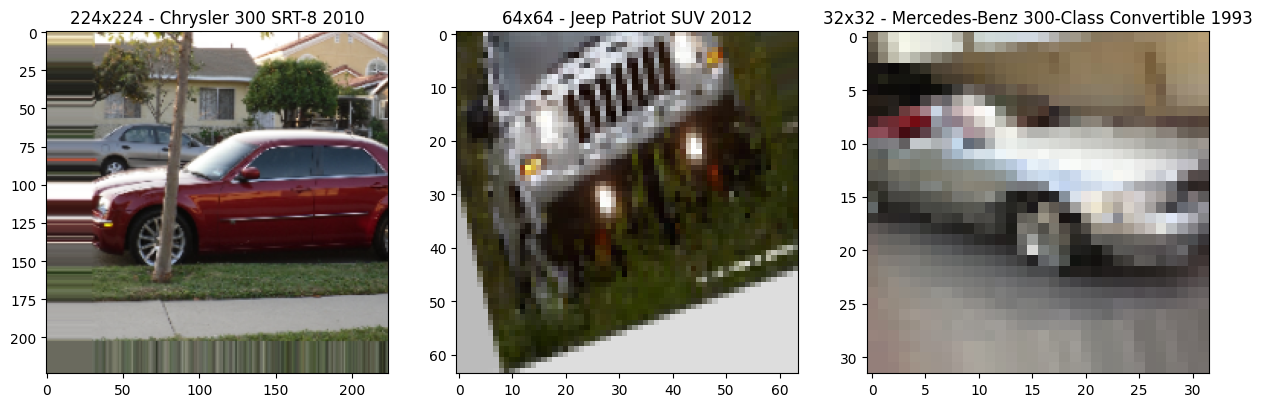

In [13]:
train_generators = {'224': train_gen_224,
                    '64': train_gen_64,
                    '32': train_gen_32}

plot_imgs_from_generator(train_generators, ncols=len(train_generators))

## CNN Models (*Convolutional Neural Network*) 

### LeNet Model


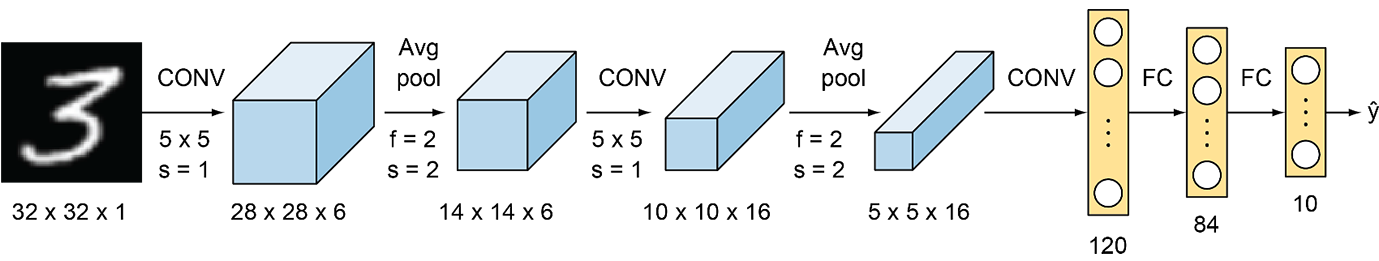


El modelo **LeNet** es una de las primeras redes neuronales convolucionales que se crearon. Fue creada por Yann LeCun en 1998 y fue diseñada para reconocer dígitos escritos a mano. El modelo LeNet se compone de 7 capas una capa de entrada, 4 capas convolucionales y 2 capas densas. La capa de entrada recibe una imagen de 32x32 píxeles. Las 4 capas convolucionales se encargan de extraer las características de la imagen. Las 2 capas densas se encargan de clasificar las características extraídas por las capas convolucionales. Hace uso de la función de activación **tahn** en las capas convolucionales y de la función de activación **softmax** en la capa de salida.

Dado que **LeNet** es un modelo simple y específico para reconocer dígitos escritos a mano, se ha optado por reducir el número de clases de coches a 10 y observar el comportamiento del modelo.

In [14]:
# Clear session
tf.keras.backend.clear_session()

# Clear GPU memory
tf.compat.v1.reset_default_graph()

In [15]:
# Set random seed
np.random.seed(42)
tf.random.set_seed(42)

In [16]:
# Create LeNet model
ln = LeNet(input_shape=TARGET_SIZE_32 + (1,), num_classes=num_classes, see_summary=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (Average  (None, 14, 14, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 120)         48120 

In [17]:
# Train the model
ln_history = ln.train(train_generator=train_gen_32, validation_generator=val_gen_32, epochs=30, verbose=1, patience=4)

Model not found
Training model...
Epoch 1/30
207/207 [==============================] - ETA: 0s - loss: 5.2805 - accuracy: 0.0055
Epoch 1: val_loss improved from inf to 5.27642, saving model to models/checkpoints/lenet
INFO:tensorflow:Assets written to: models/checkpoints/lenet/assets


INFO:tensorflow:Assets written to: models/checkpoints/lenet/assets


207/207 [==============================] - 74s 349ms/step - loss: 5.2805 - accuracy: 0.0055 - val_loss: 5.2764 - val_accuracy: 0.0058
Epoch 2/30
 81/207 [==========>...................] - ETA: 35s - loss: 5.2675 - accuracy: 0.0058

In [ ]:
# Evaluate the model
ln_loss, ln_acc = ln.evaluate(test_gen_32)
plot_evaluation(history=ln_history)

In [ ]:
# Predictions
ln_prediction = ln.predict(test_gen_32)   
plot_comparison(df_test=test, model_names=model_names, predicted_classes=ln_prediction)

## AlexNet Model

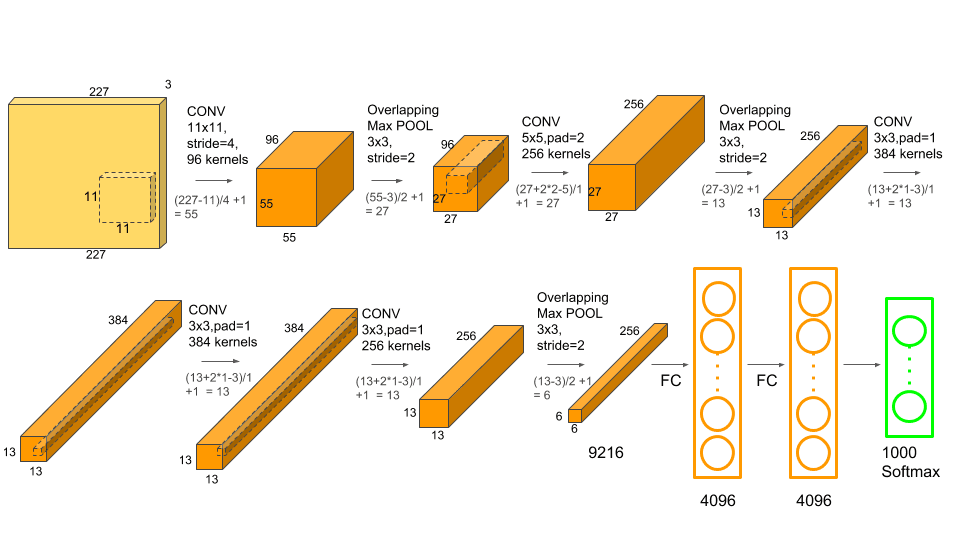

AlexNet es una red neuronal convolucional profunda que fue creada por Alex Krizhevsky, Ilya Sutskever y Geoffrey Hinton en 2012. Fue la primera red neuronal convolucional en ganar el concurso ImageNet Large Scale Visual Recognition Challenge (ILSVRC) en 2012. El modelo AlexNet se compone de 8 capas una capa de entrada, 5 capas convolucionales y 3 capas densas. La capa de entrada recibe una imagen de 227x227 píxeles. La entrada del modelo es una imagen RGB de 227x227x3. Hace uso de la función de activación **ReLU** en las capas convolucionales y de la función de activación **softmax** en la capa de salida.

In [ ]:
# Clear session
tf.keras.backend.clear_session()

# Clear GPU memory
tf.compat.v1.reset_default_graph()

In [ ]:
# Set random seed
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Create AlexNet model
an = AlexNet(input_shape=TARGET_SIZE_227 + (3,), num_classes=num_classes, see_summary=True)

In [ ]:
# Train the model
an_history = an.train(train_generator=train_gen_227, validation_generator=val_gen_227, patience=4, verbose=1)

In [ ]:
# Evaluate the model
an_loss, an_acc = an.evaluate(test_gen_224)
plot_evaluation(history=an_history)

In [ ]:
# Predictions
an_prediction = an.predict(test_gen_64)
plot_comparison(df_test=test, model_names=model_names, predicted_classes=an_prediction)

## VGG-16

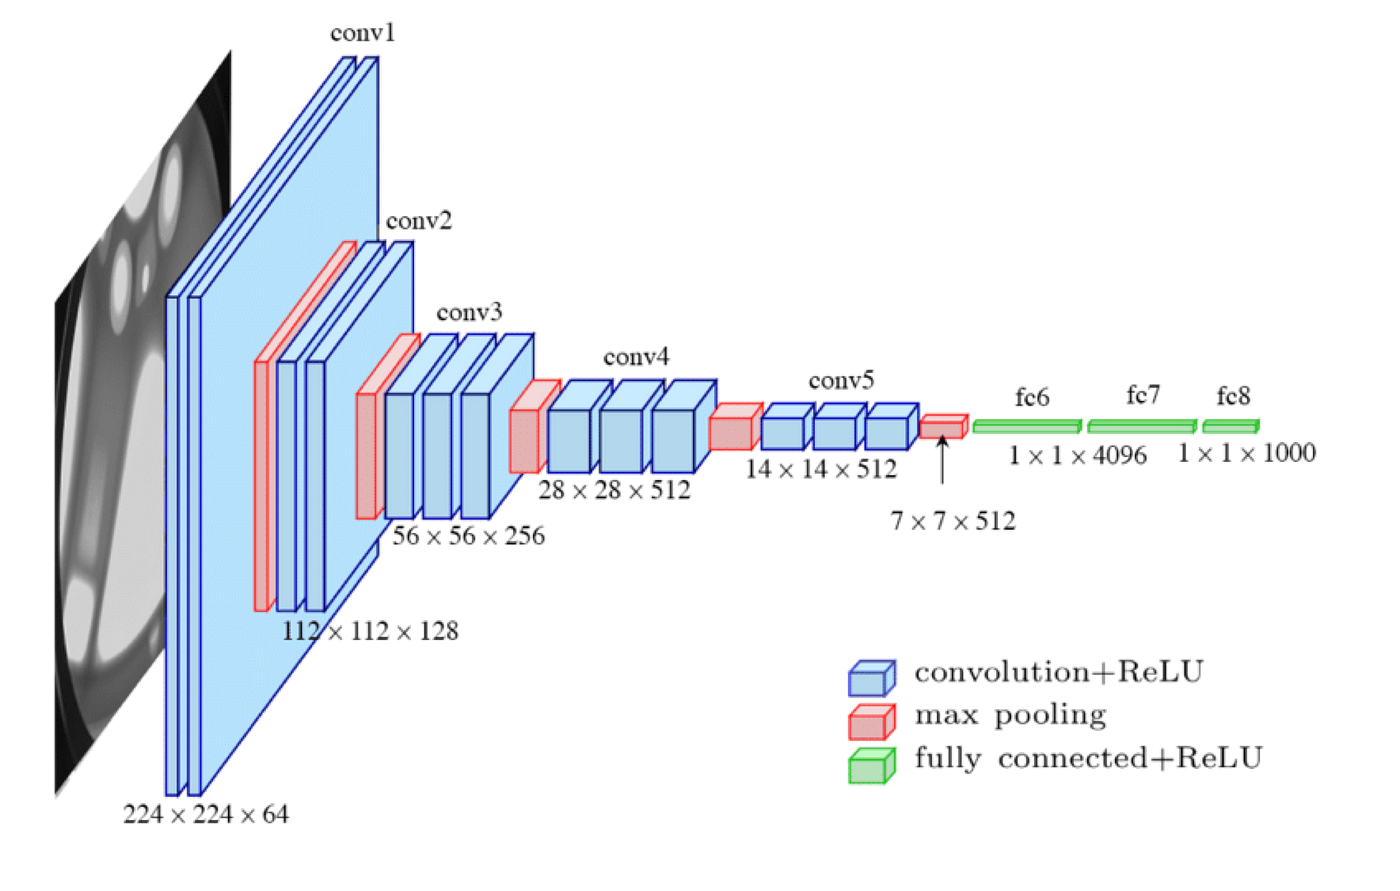

In [ ]:
# Clear session
tf.keras.backend.clear_session()

# Clear GPU memory
tf.compat.v1.reset_default_graph()

In [ ]:
# Set random seed
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Create VGG16 model
vgg16 = VGG16(input_shape=TARGET_SIZE_224 + (3,), num_classes=num_classes, see_summary=False)

In [ ]:
# Train the model
vgg16_history = vgg16.train(train_generator=train_gen_224, validation_generator=val_gen_224, patience=3, epochs=30)

In [ ]:
# Evaluate the model
vgg16_loss, vgg16_acc = vgg16.evaluate(test_gen_224)
plot_evaluation(history=vgg16_history)

In [ ]:
# Predictions
vgg16_prediction = vgg16.predict(test_gen_224)
plot_comparison(df_test=test, model_names=model_names, predicted_classes=vgg16_prediction)

## GoogLeNet y Inception


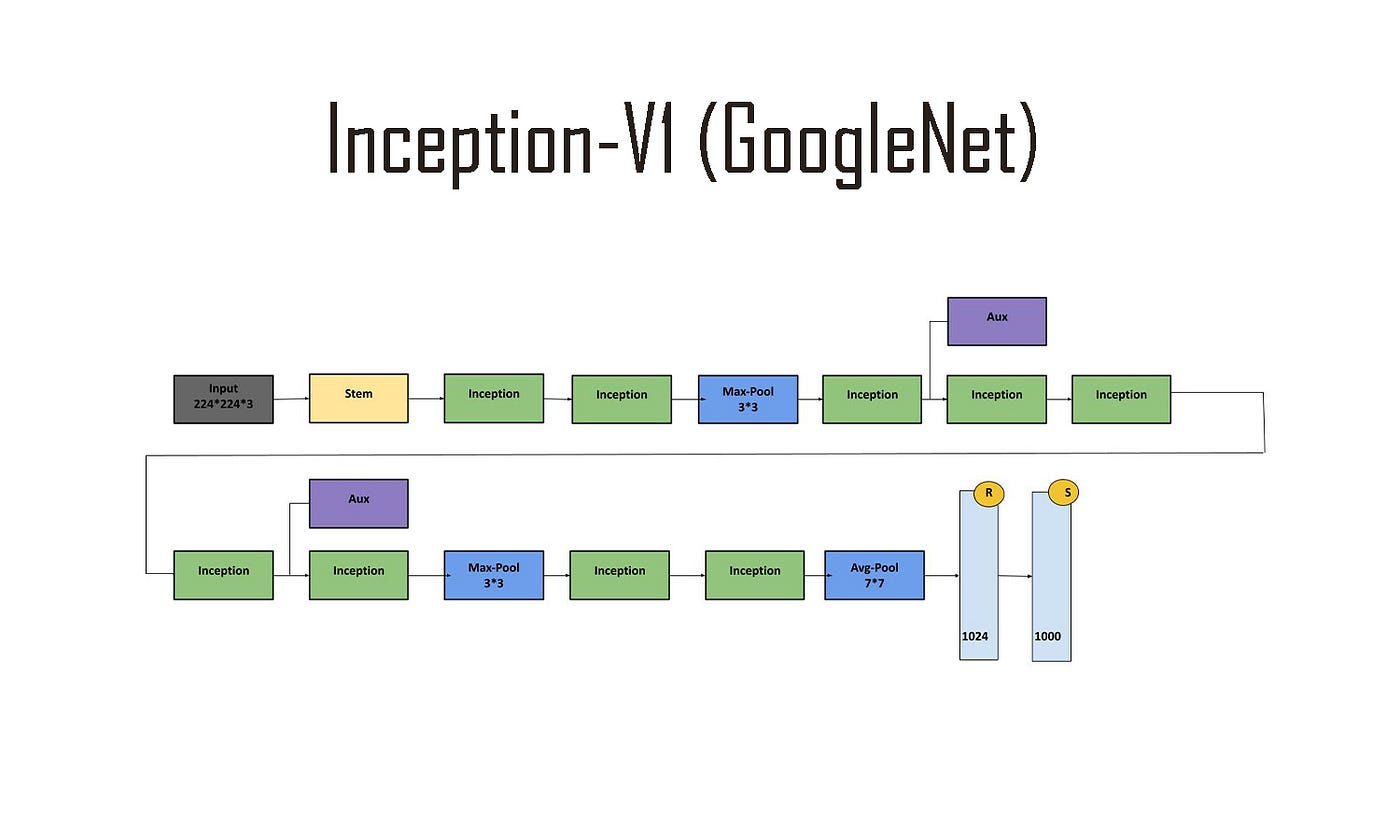

In [ ]:
# Clear session
tf.keras.backend.clear_session()

# Clear GPU memory
tf.compat.v1.reset_default_graph()

In [ ]:
# Set random seed
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Create GoogleLeNet model
gln = GoogleNet(input_shape=TARGET_SIZE_224 + (3,), num_classes=num_classes, see_summary=True)

In [ ]:
# Train the model
gln_history = gln.train(train_generator=train_gen_224, validation_generator=val_gen_224, patience=4)

In [ ]:
# Evaluate the model
gln_loss, gln_acc = gln.evaluate(test_gen_224)
plot_evaluation(history=gln_history)

In [ ]:
gln_prediction = gln.predict(test_gen_224)
plot_comparison(df_test=test, model_names=model_names, predicted_classes=gln_prediction)

## ResNet-50 Model

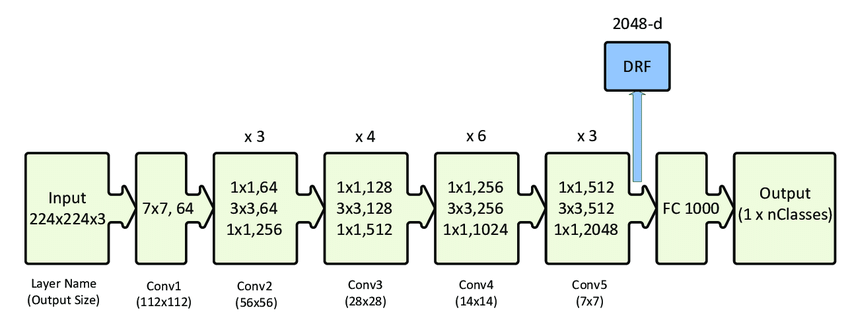

In [ ]:
# Clear session
tf.keras.backend.clear_session()

# Clear GPU memory
tf.compat.v1.reset_default_graph()

In [ ]:
# Set random seed
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Create ResNet50 model
rn50 = ResNet50(input_shape=TARGET_SIZE_224 + (3,), num_classes=num_classes, see_summary=True)

In [ ]:
# Train the model
rn50_history = rn50.train(train_generator=train_gen_224, validation_generator=val_gen_224, patience=5, epochs=50, batch_size=BATCH_SIZE_8)

In [ ]:
# Evaluate the model
rn50_loss, rn50_acc = rn50.evaluate(test_gen_224)
plot_evaluation(history=rn50_history)

In [ ]:
# Predictions
rn50_prediction = rn50.predict(test_gen_224)
plot_comparison(df_test=test, model_names=model_names, predicted_classes=rn50_prediction)

## Conclusiones

In [ ]:
# Plot the losses and accuracies of all models in a bar plot
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.bar(x=['CNN', 'LeNet5', 'AlexNet', 'VGG16', 'GoogleNet', 'ResNet50'],
        height=[ln_loss, an_loss, vgg16_loss, gln_loss, rn50_loss])

plt.title('Losses'), plt.ylabel('Loss'), plt.xlabel('Model')


plt.subplot(1, 2, 2)
plt.bar(x=['LeNet5', 'AlexNet', 'VGG16', 'GoogleNet', 'ResNet50'],
        height=[ln_acc, an_acc, vgg16_acc, gln_acc, rn50_acc])

plt.title('Accuracies'), plt.ylabel('Accuracy'), plt.xlabel('Model')

plt.show()

## Clasificación de imágenes con Ruido

In [ ]:
# Clear session
tf.keras.backend.clear_session()

# Clear GPU memory
tf.compat.v1.reset_default_graph()

In [ ]:
target_size = (224, 224)
batch_size = 32

In [ ]:

# For each img, add black pixels randomly to the whole img. There can be different sizes of black pixels
def add_random_black_pixels(img, num_pixels):
    
    # Get image size
    img_size = img.shape[0]
    
    # Create random black pixels
    for _ in range(num_pixels):
        
        # Random size of black pixels
        size = np.random.randint(1, 20)
        
        # Random location of black pixels
        x = np.random.randint(0, img_size)
        y = np.random.randint(0, img_size)
        
        # Add black pixels to image
        img[x:x+size, y:y+size, :] = 0
        
    return img

In [ ]:
# Apply random black pixels to each image
black_pixels = 100   # Number of black pixels to add to each image

# Create new train and test generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   preprocessing_function=lambda x: add_random_black_pixels(x, black_pixels))

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training')

test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(test_path,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        subset='validation')

In [ ]:
# Visualize images with black pixels
x, y = train_generator.next()

# Class labels
class_labels = train_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}

figs, axs = plt.subplots(ncols=4, figsize=(20, 10))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(x[i])
    ax.set_title(class_labels[np.argmax(y[i])])
    ax.axis('off')

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

# Create an autoencoder model to try and remove the black pixels
def Autoencoder_Model(input_shape):
    
    img_input = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(filters=16, kernel_size=3, activation='relu', padding='same')(img_input)
    x = MaxPooling2D(pool_size=2, padding='same')(x)
    
    x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=2, padding='same')(x)
    
    x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=2, padding='same')(x) 
    
    x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x) 
    x = MaxPooling2D(pool_size=2, padding='same')(x)
    
    
    # Decoder
    x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
    x = UpSampling2D(size=2)(x)
    
    x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = UpSampling2D(size=2)(x)
    
    x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
    x = UpSampling2D(size=2)(x)
    
    x = Conv2D(filters=3, kernel_size=3, activation='sigmoid', padding='same')(x)  
    output = UpSampling2D(size=2)(x)
    
    model = Model(inputs=img_input, outputs=output)
    
    return model

In [ ]:
input_shape = target_size + (3,)
num_classes = len(model_names)

autoencoder = Autoencoder_Model(input_shape)

autoencoder.compile(loss='mse',
                          optimizer='adam',
                          metrics=['accuracy'])

autoencoder.summary()

In [ ]:
try:
    # Open model file
    autoencoder = load_model('autoencoder')
    with open('autoencoder/autoencoder_history.pkl', 'rb') as f:
        autoencoder_history = pickle.load(f)
        
except Exception as e:
    print(e)
    autoencoder_history = autoencoder.fit(train_generator,
                                          epochs=100,
                                          validation_data=validation_generator)
    
    # Save model
    autoencoder.save('autoencoder')
    
    # Save history
    with open('autoencoder/autoencoder_history.pkl', 'wb') as f:
        pickle.dump(autoencoder_history, f)

In [ ]:
# Visualize autoencoder results
x, y = train_generator.next()

# Class labels
class_labels = train_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}

figs, axs = plt.subplots(ncols=4, figsize=(20, 10))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(autoencoder.predict(x)[i])
    ax.set_title(class_labels[np.argmax(y[i])])
    ax.axis('off')              